In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [27]:
# Step 1: Load dataset
data = sm.datasets.get_rdataset("AirPassengers").data

# Convert fractional year to datetime
def fractional_year_to_datetime(year_frac):
    year = int(year_frac)
    month = int(round((year_frac - year) * 12 + 1))  # +1 because months start at 1
    return pd.Timestamp(year=year, month=month, day=1)

data['Month'] = data['time'].apply(fractional_year_to_datetime)
data.rename(columns={'value':'Passengers'}, inplace=True)
data.set_index('Month', inplace=True)

# Now 'data' is ready
ts = data['Passengers']
print(ts.head())



Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64


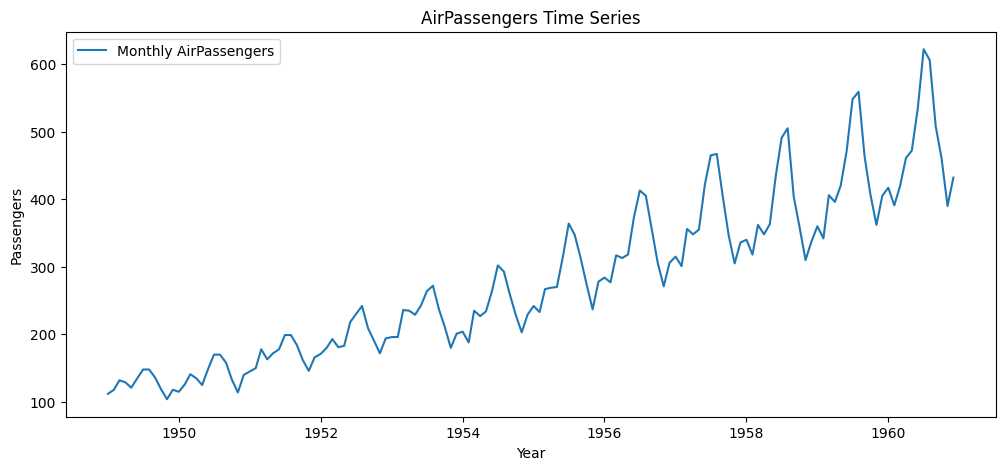

In [28]:
# Step 2: Visualize time series
plt.figure(figsize=(12,5))
plt.plot(ts, label='Monthly AirPassengers')
plt.title('AirPassengers Time Series')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.show()


### Check Stationarity (ADF Test)
#### ADF Test (Augmented Dickey-Fuller test)
- It’s a statistical test to check if your series is stationary.
- Null Hypothesis (H0): The series is non-stationary.
- Alternative Hypothesis (H1): The series is stationary.

##### Interpretation
- p-value < 0.05 - Reject H0 → Series is stationary
- p-value ≥ 0.05 - Fail to reject H0 which means Series is non-stationary 

In [29]:
# Step 3: Check stationarity using ADF
adf_result = adfuller(ts)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])




ADF Statistic: 0.8153688792060352
p-value: 0.9918802434376408


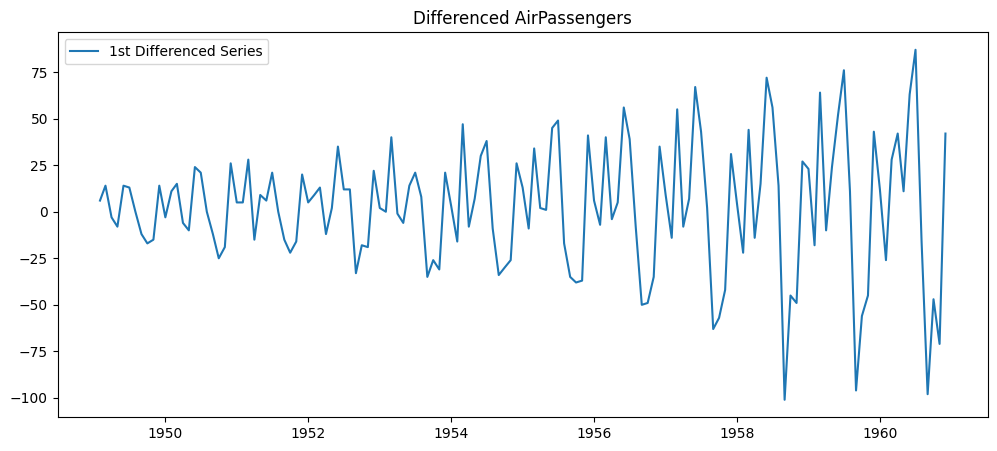

ADF Statistic (diff): -2.8292668241699945
p-value (diff): 0.05421329028382621


In [30]:
# Step 4: Differencing to remove trend
ts_diff = ts.diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(ts_diff, label='1st Differenced Series')
plt.title('Differenced AirPassengers')
plt.legend()
plt.show()

# Check stationarity after differencing
adf_result_diff = adfuller(ts_diff)
print("ADF Statistic (diff):", adf_result_diff[0])
print("p-value (diff):", adf_result_diff[1])

In [31]:
ts_diff2 = ts.diff().diff().dropna()
adf_result2 = adfuller(ts_diff2)
print("ADF Statistic (2nd diff):", adf_result2[0])
print("p-value (2nd diff):", adf_result2[1])


ADF Statistic (2nd diff): -16.38423154246852
p-value (2nd diff): 2.732891850014085e-29


### ACF (Autocorrelation Function) Plot
- What it does:
   - Checks how much the current value of your series is related to its past values (lags).
- Example:
   - Lag 1 - today’s value vs yesterday’s value.
   - Lag 2 - today’s value vs 2 days ago.
   - Lag 3 - today’s value vs 3 days ago… and so on.
- How it looks:
   - If ACF has many significant spikes gradually decreasing → suggests AR process (current values depend on many past values).
   - If ACF cuts off sharply after a certain lag → suggests MA process (current values depend on past errors up to that lag).


### PACF (Partial Autocorrelation Function) Plot
- What it does:
   - Similar to ACF, but it removes the "indirect effects".
- Example:
   - if today depends on yesterday, and yesterday depends on 2 days ago, then PACF at lag 2 will remove yesterday’s effect to check the direct link between today and 2 days ago.
- How it looks:
   - If PACF cuts off after lag p - suggests AR(p).
   - If PACF tails off gradually - suggests MA(q)


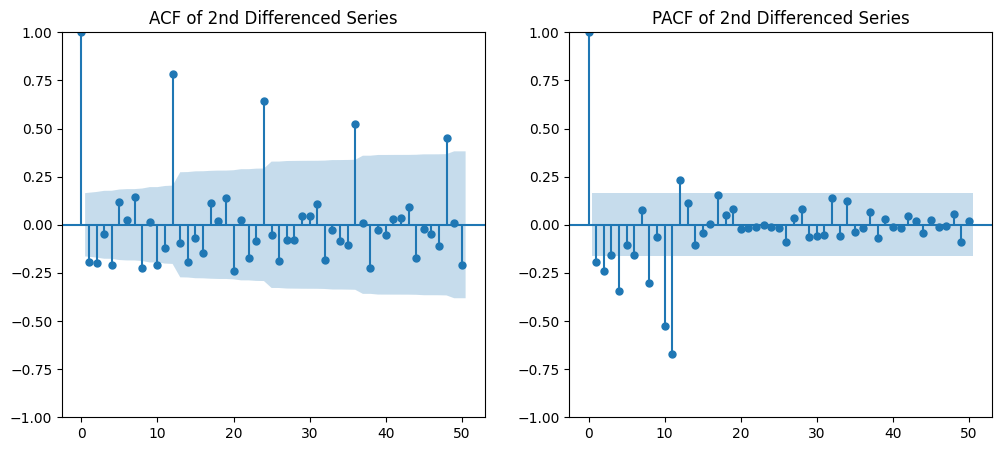

In [32]:
# Step 5: ACF and PACF to select p and q
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(ts_diff2, lags=50, ax=plt.gca())
plt.title('ACF of 2nd Differenced Series')
plt.subplot(122)
plot_pacf(ts_diff2, lags=50, method='ywm', ax=plt.gca())
plt.title('PACF of 2nd Differenced Series')
plt.show()




## Choosing p and q 
#### - p = AR order (autoregressive)
#### - d = differencing order
#### - q = MA order (moving average)

### Intepreting ACF (left plot)
- The Autocorrelation Function (ACF) shows correlation of the series with its own lagged values.
- For your 2nd differenced series:
  - Big spikes at lags 10, 20, 30… suggest seasonality around lag 10.
  - The ACF tails off (gradual decay) instead of cutting off sharply, which usually points towards an AR (AutoRegressive) component rather than a pure MA.
  - First few lags (especially lag 1) are significant, but not a clean cutoff → try q = 0 or 1.
    
### Intepreting PACF (right plot)
- The Partial Autocorrelation Function (PACF) shows the “direct” correlation between the series and its lag, after removing effects of earlier lags.
- For your 2nd differenced series:
  - There’s a clear strong spike at lag 1, and possibly a smaller one at lag 2.
  - After lag 2, the spikes die down into the confidence band.
  - This suggests that an AR(1) or AR(2) process is a good candidate.
d=2

ARIMA(1,2,0)

ARIMA(1,2,1)

ARIMA(2,2,1)


In [33]:
models = [(1,2,0), (1,2,1), (2,2,1)]
results = {}

for order in models:
    model = ARIMA(ts, order=order)
    fit = model.fit()
    results[order] = fit
    print(f"ARIMA{order} - AIC:{fit.aic:.2f}, BIC:{fit.bic:.2f}")


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-pa

ARIMA(1, 2, 0) - AIC:1447.03, BIC:1452.94
ARIMA(1, 2, 1) - AIC:1398.93, BIC:1407.80


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 1) - AIC:1393.89, BIC:1405.71


#### AIC
- AIC is a score that tells you how good a model is.
- Lower AIC = better model.


In [36]:
# Choose the model with the lowest AIC/BIC
best_order = min(results, key=lambda k: results[k].aic)
print(f"Best model by AIC: ARIMA{best_order}")


Best model by AIC: ARIMA(2, 2, 1)


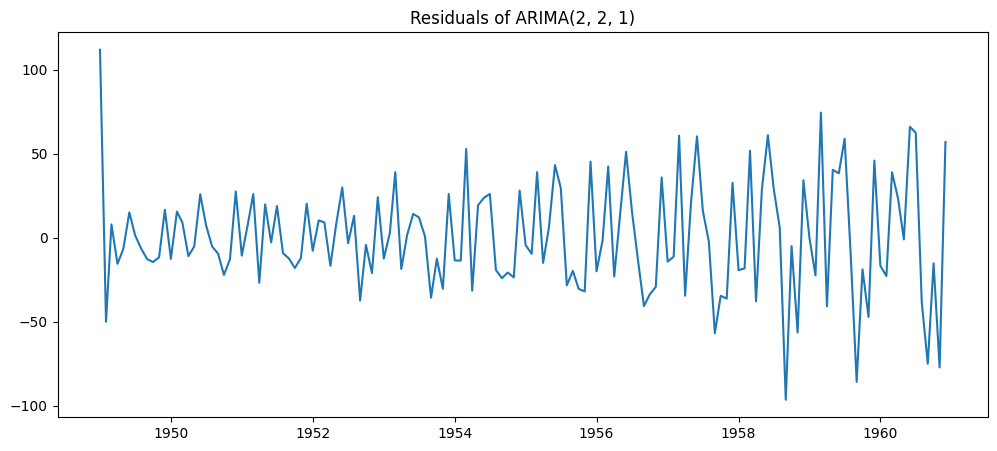

In [37]:
best_model = results[best_order]
residuals = best_model.resid

plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title(f'Residuals of ARIMA{best_order}')
plt.show()



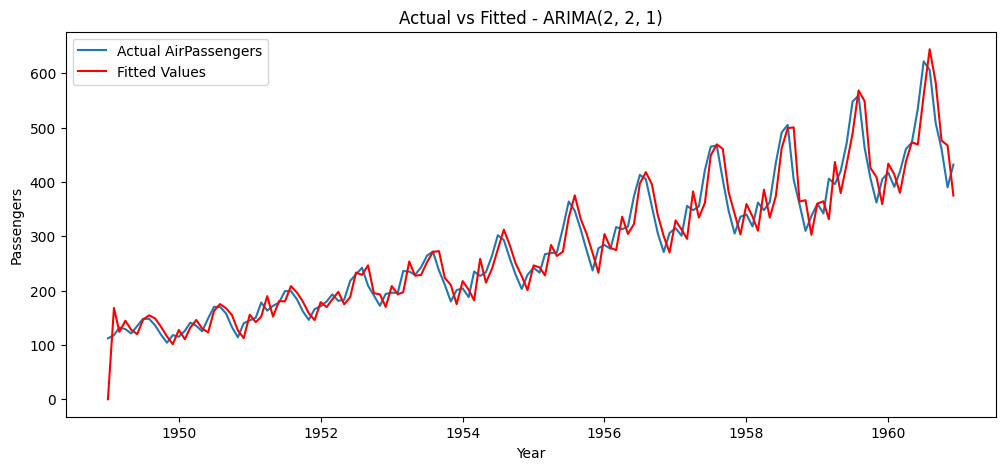

In [40]:
fitted = best_model.predict(start=0, end=len(ts)-1)

plt.figure(figsize=(12,5))
plt.plot(ts, label='Actual AirPassengers')
plt.plot(fitted, color='red', label='Fitted Values')
plt.title(f'Actual vs Fitted - ARIMA{best_order}')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.show()


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_23804\633850792.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=ts.index[-1]+pd.offsets.MonthBegin(), periods=forecast_steps, freq='M')


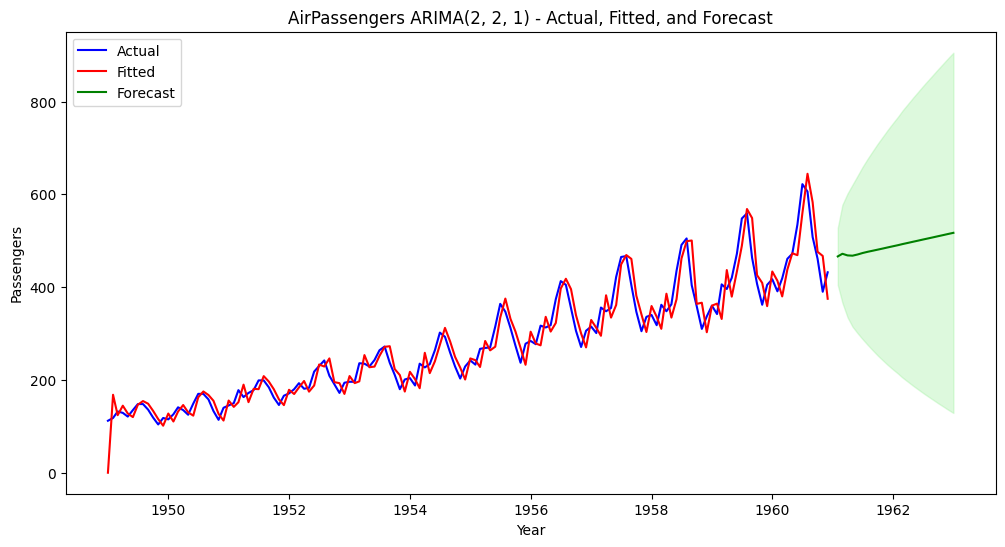

In [41]:
forecast_steps = 24
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts.index[-1]+pd.offsets.MonthBegin(), periods=forecast_steps, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
conf_int = forecast.conf_int()
conf_int.index = forecast_index

# Step 3: Plot Actual, Fitted, and Forecast
plt.figure(figsize=(12,6))
plt.plot(ts, label='Actual', color='blue')
plt.plot(fitted, label='Fitted', color='red')
plt.plot(forecast_series, label='Forecast', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='lightgreen', alpha=0.3)
plt.title(f'AirPassengers ARIMA{best_order} - Actual, Fitted, and Forecast')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.show()


#### SARIMA

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [43]:
#Check stationarity (ADF test)
adf_result = adfuller(ts)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])




ADF Statistic: 0.8153688792060352
p-value: 0.9918802434376408


In [50]:
# Seasonal differencing (D=1)
ts_seasonal_diff = ts.diff(12).dropna()

# Non-seasonal differencing (d=1)
ts_diff = ts_seasonal_diff.diff().dropna()

# Check stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -15.595618083746334
p-value: 1.8565116001234705e-28


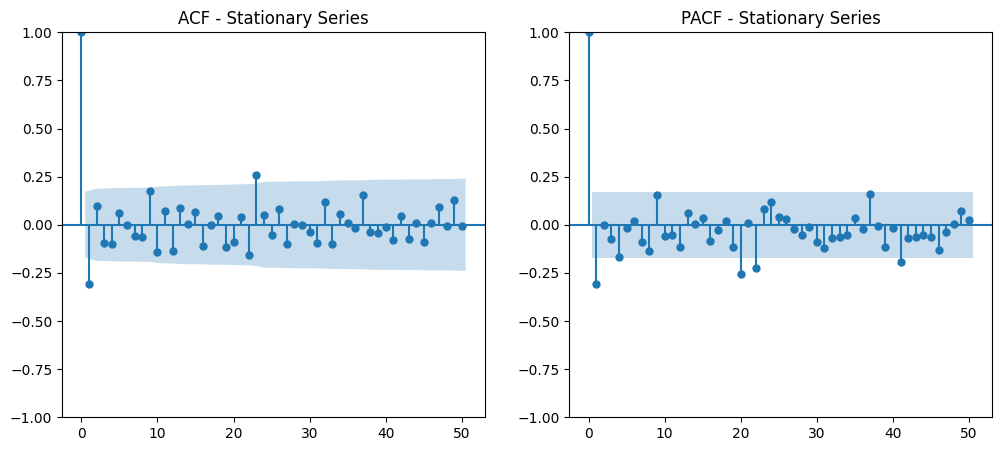

In [51]:
# Plot ACF and PACF of stationary series (ts_diff)

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(ts_diff, lags=50, ax=plt.gca())
plt.title('ACF - Stationary Series')
plt.subplot(122)
plot_pacf(ts_diff, lags=50, method='ywm', ax=plt.gca())
plt.title('PACF - Stationary Series')
plt.show()



In [52]:
#  Fit SARIMA model
# Baseline: (p,d,q) = (1,1,1), seasonal (P,D,Q,s) = (1,1,1,12)
p,d,q = 1,1,1
P,D,Q,s = 1,1,1,12

In [53]:
sarima_model = SARIMAX(ts, order=(p,d,q), seasonal_order=(P,D,Q,s))
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())



C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Thu, 02 Oct 2025   AIC                           1022.299
Time:                                    04:03:41   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2149      0.325   

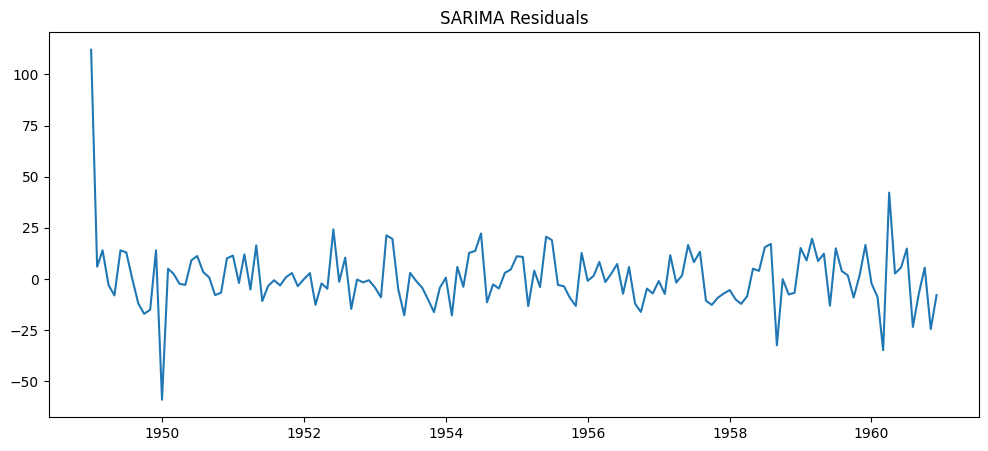

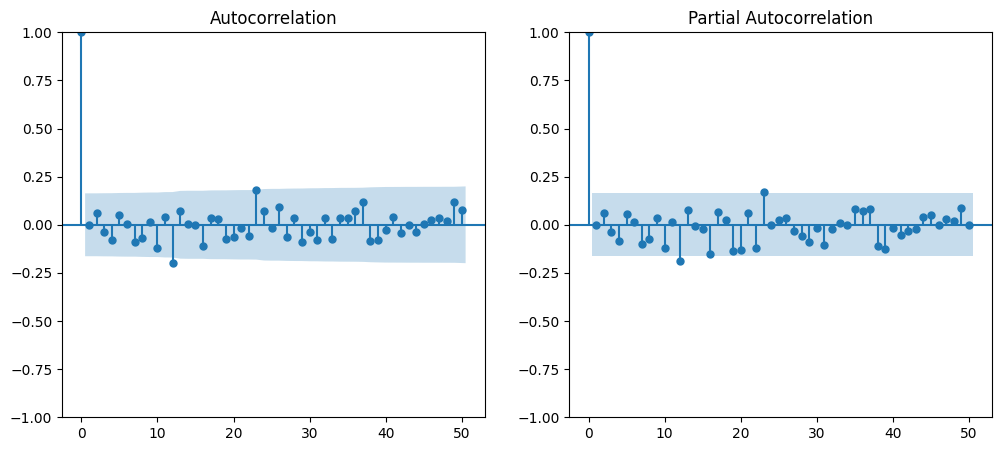

In [54]:
#  Residual analysis
residuals = sarima_fit.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title('SARIMA Residuals')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(residuals, lags=50, method='ywm', ax=plt.gca())
plt.show()



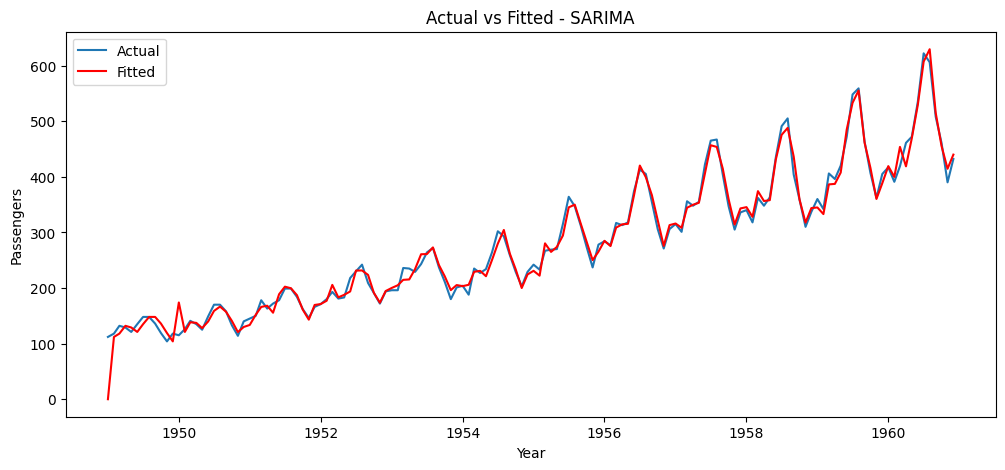

In [55]:
#  Fitted values (original scale)
fitted = sarima_fit.fittedvalues
plt.figure(figsize=(12,5))
plt.plot(ts, label='Actual')
plt.plot(fitted, color='red', label='Fitted')
plt.title('Actual vs Fitted - SARIMA')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.show()


C:\Users\AARUSHI TANDON\AppData\Local\Temp\ipykernel_23804\280728379.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=ts.index[-1]+pd.offsets.MonthBegin(), periods=forecast_steps, freq='M')


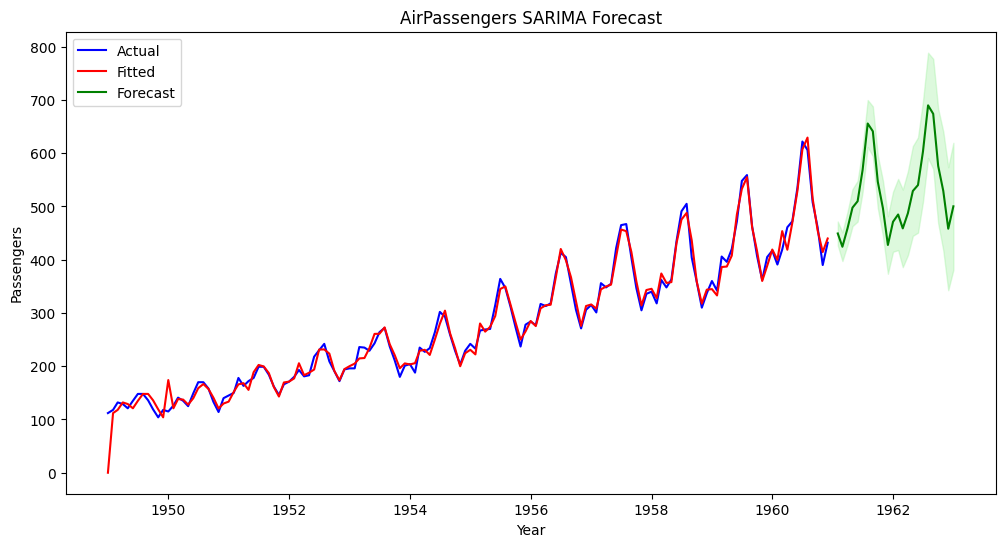

In [56]:

# Step 5: Forecast next 24 months
forecast_steps = 24
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts.index[-1]+pd.offsets.MonthBegin(), periods=forecast_steps, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
conf_int = forecast.conf_int()
conf_int.index = forecast_index

plt.figure(figsize=(12,6))
plt.plot(ts, label='Actual', color='blue')
plt.plot(fitted, label='Fitted', color='red')
plt.plot(forecast_series, label='Forecast', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='lightgreen', alpha=0.3)
plt.title('AirPassengers SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.show()
